# STOCHASTIC CLIMATE EMULATORS FOR COASTAL HAZARDS
### UCSC - Nov 2024


<img src="images/Image_3.png" alt="Texto alternativo" width="400">  


## TESLA: 06 - CLIMATE BASED EMULATOR


---

Fernando J.Mendez (fernando.mendez@unican.es)

Full Profesor at the Univeristy of Cantabria

---

Jared Ortiz-Angulo Cantos (ortizanguloj@unican.es)

Researcher

---

Geomatics and Ocean Engineering Group

Civil Engineering School, University of Cantabria

<img src="images/Image_1.png" alt="Texto alternativo" width="200">               <img src="images/Image_2.jpeg" alt="Texto alternativo" width="200">

<img src="images/Image_4.jpeg" alt="Texto alternativo" width="800"> 

© GeoOcean 2024 - University of Cantabria


---

Inputs required:
  * Predictand data
  
In this notebook:
  1. Import required libraries and paths
  2. Load data
  3. Gaussian Copula
  4. Validation
  5. Climate-based Emulator
  6. Results


---

## **1. Import required libraries and paths**

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=DeprecationWarning)

import os
import os.path as op
import sys

import numpy as np
import pandas as pd
import xarray as xr

# matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pylab
import matplotlib

# Principal component analysis and kmeans libs
from sklearn.decomposition import PCA

In [2]:
from bluemath_tk.teslakit2.toolkit.pca import PCA_EstelaPred_slp_grd
from bluemath_tk.copula_UCSC_v3 import *

In [3]:
# paths
p_dat = ('/home/ortizaj/Desktop/UCSC/github_new/TESLA_UCSC/data')
p_out = ('/home/ortizaj/Desktop/UCSC/github_new/TESLA_UCSC/results')

---

## **2. LOAD DATA**

In [4]:
# Load Predictand (WAVES)
ds = xr.open_dataset(op.join(p_dat,'hainan_data.nc'))
ds

<xarray.Dataset> Size: 17MB
Dimensions:     (time: 350640)
Coordinates:
  * time        (time) datetime64[ns] 3MB 1979-01-01 ... 2018-12-31T23:00:00
    latitude    float32 4B ...
    longitude   float32 4B ...
Data variables:
    Hs          (time) float64 3MB ...
    Tm          (time) float64 3MB ...
    Dir         (time) float64 3MB ...
    surge       (time) float64 3MB ...
    waterlevel  (time) float64 3MB ...

In [5]:
# Resample daily

ds = ds.resample(time='D').interpolate('linear')  
ds = ds.rename({"surge": "ss", "Tm": "Tp"})


In [6]:
# Load KMA info (from CODE_01)
KMA = xr.open_dataset(op.join(p_out,'DWT_KMA_eofs.nc'))
KMA # Check it out!

<xarray.Dataset> Size: 371kB
Dimensions:      (n_components: 30572, n_clusters: 9, n_features: 59)
Dimensions without coordinates: n_components, n_clusters, n_features
Data variables:
    sorted_bmus  (n_components) int32 122kB ...
    kma_order    (n_clusters) int64 72B ...
    cluster      (n_clusters) int64 72B ...
    cenEOFs      (n_clusters, n_features) float64 4kB ...
    time         (n_components) datetime64[ns] 245kB ...

In [7]:
# Define common times
t_min=np.nanmax([np.nanmin(ds.time.values), np.nanmin(KMA.time.values)])
t_max=np.nanmin([np.nanmax(ds.time.values), np.nanmax(KMA.time.values)])

In [8]:
# Find positions in KMA
t_min_pos = np.where(KMA['time'] == t_min)[0][0]
t_max_pos = np.where(KMA['time'] == t_max)[0][0]


In [9]:
KMA = KMA.isel(n_components=slice(t_min_pos, t_max_pos+1))  # Slice to have the same time serie
KMA # check it out!

<xarray.Dataset> Size: 180kB
Dimensions:      (n_components: 14610, n_clusters: 9, n_features: 59)
Dimensions without coordinates: n_components, n_clusters, n_features
Data variables:
    sorted_bmus  (n_components) int32 58kB ...
    kma_order    (n_clusters) int64 72B ...
    cluster      (n_clusters) int64 72B ...
    cenEOFs      (n_clusters, n_features) float64 4kB ...
    time         (n_components) datetime64[ns] 117kB 1979-01-01 ... 2018-12-31

In [10]:
clusters = KMA.sorted_bmus.values # obtain the clusters info

ds['bmus'] = ('time', clusters) # add extra data to WAVES dataset
ds # check it out!

<xarray.Dataset> Size: 760kB
Dimensions:     (time: 14610)
Coordinates:
    latitude    float32 4B 22.6
    longitude   float32 4B 121.4
  * time        (time) datetime64[ns] 117kB 1979-01-01 1979-01-02 ... 2018-12-31
Data variables:
    Hs          (time) float64 117kB 1.544 1.988 1.401 ... 1.421 2.739 1.734
    Tp          (time) float64 117kB 8.233 7.076 8.22 ... 7.246 6.655 6.824
    Dir         (time) float64 117kB 91.5 56.62 80.41 ... 78.89 36.95 62.61
    ss          (time) float64 117kB 0.926 0.749 0.084 ... 0.469 0.374 0.201
    waterlevel  (time) float64 117kB -0.096 -0.219 -0.73 ... 0.254 0.438 0.459
    bmus        (time) int32 58kB 1 1 1 1 1 1 1 1 1 1 1 ... 3 3 3 3 3 3 3 2 0 2

In [11]:
# interpolate nans
ds = ds.interpolate_na(dim = 'time', method = 'linear')

# Variables of interest
vars = ['Hs', 'Tp', 'Dir', 'ss', 'bmus']

# Drop rest of variables
ds = ds.drop_vars([var for var in ds if var not in vars])

ds # check it out!

<xarray.Dataset> Size: 643kB
Dimensions:    (time: 14610)
Coordinates:
    latitude   float32 4B 22.6
    longitude  float32 4B 121.4
  * time       (time) datetime64[ns] 117kB 1979-01-01 1979-01-02 ... 2018-12-31
Data variables:
    Hs         (time) float64 117kB 1.544 1.988 1.401 1.75 ... 1.421 2.739 1.734
    Tp         (time) float64 117kB 8.233 7.076 8.22 7.028 ... 7.246 6.655 6.824
    Dir        (time) float64 117kB 91.5 56.62 80.41 63.65 ... 78.89 36.95 62.61
    ss         (time) float64 117kB 0.926 0.749 0.084 ... 0.469 0.374 0.201
    bmus       (time) int32 58kB 1 1 1 1 1 1 1 1 1 1 1 ... 5 3 3 3 3 3 3 3 2 0 2

In [12]:
# get number of clusters
num_clusters = len(np.unique(ds.bmus))
num_clusters = num_clusters
num_clusters

9

---

## **3. GAUSSIAN COPULA**

In [13]:
kernels = ['GEV','ECDF', 'ECDF', 'ECDF'] # [Hs, Tp, Dir, SS]

# ECDF: Empirical Cumulative Distribution Function

In [14]:
time = ds.time
variables = ['Hs','Tp', 'Dir', 'ss']

In [15]:
# Create Folders: Figures and Results
#os.makedirs(os.path.join(p_out,'Figures'))
#os.makedirs(os.path.join(p_out,'Results'))

In [16]:
num_sims = 1 # number of simulations for the copulas
num_sim_cluster = 1000 # number of values obtained from each copula simulation

In [17]:
Copula_Hs_Tp_Dir_ss(p_out,ds,num_clusters,kernels,variables,num_sim_cluster)

0
1
2
3
4
5


6
7
8


In [18]:
copula_check = xr.open_dataset(op.join(p_out,'Copula_Parameters_0.nc'))
copula_check

<xarray.Dataset> Size: 40kB
Dimensions:  (num: 1000)
Coordinates:
  * num      (num) int64 8kB 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
Data variables:
    Hs_cop   (num) float64 8kB ...
    Tp_cop   (num) float64 8kB ...
    Dir_cop  (num) float64 8kB ...
    ss_cop   (num) float64 8kB ...

---

## **4. CLIMATE-BASED EMULATOR**

In [19]:
# Now we need the synthetic series of DWT
DWT_ALR = xr.open_dataset(op.join(p_out,'DWT_ALR.nc'))

In [20]:
DWT_ALR # check it out

<xarray.Dataset> Size: 2MB
Dimensions:      (time: 36525, n_sim: 5)
Coordinates:
  * time         (time) datetime64[ns] 292kB 1900-01-01 ... 2000-01-01
Dimensions without coordinates: n_sim
Data variables:
    evbmus_sims  (time, n_sim) int64 1MB ...

In [21]:
num_sims = len(DWT_ALR.n_sim)
num_sims

5

In [22]:
def Emulator(main_path, ds, num_sims):

    path_save = os.path.join(main_path, 'Emulator_Sims')

    # Crear un Dataset fuera del bucle para almacenar los resultados de todas las simulaciones
    ds_sim = xr.Dataset(
        {'Hs': (('sim', 'time'), np.full([num_sims, len(DWT_ALR.time.values)], np.nan)),
         'Tp': (('sim', 'time'), np.full([num_sims, len(DWT_ALR.time.values)], np.nan)),
         'Dir': (('sim', 'time'), np.full([num_sims, len(DWT_ALR.time.values)], np.nan)),
         'ss': (('sim', 'time'), np.full([num_sims, len(DWT_ALR.time.values)], np.nan))},

        coords={'sim': range(num_sims), 'time': DWT_ALR.time.values})


    for sim in range(num_sims):

        print('Sim:', sim)

        bmus = DWT_ALR['evbmus_sims'].sel(n_sim=sim).values
        Hs_emu = np.full([len(DWT_ALR.time.values)], np.nan)
        Tp_emu = np.full([len(DWT_ALR.time.values)], np.nan)
        Dir_emu = np.full([len(DWT_ALR.time.values)], np.nan)
        ss_emu = np.full([len(DWT_ALR.time.values)], np.nan)


        for pos, dwt in enumerate(bmus):

            cop = xr.open_dataset(os.path.join(main_path, 'Copula_Parameters_' + str(round(bmus[pos])-1) + '.nc'))
            rnd_val = np.random.randint(0, len(cop.num), 1)

            Hs_emu[pos] = cop.Hs_cop[rnd_val]
            Tp_emu[pos] = cop.Tp_cop[rnd_val]
            Dir_emu[pos] = cop.Dir_cop[rnd_val]
            ss_emu[pos] = cop.ss_cop[rnd_val]

        # Agregar los resultados de la simulación actual al Dataset ds_sim
        ds_sim['Hs'][sim, :] = Hs_emu
        ds_sim['Tp'][sim, :] = Tp_emu
        ds_sim['Dir'][sim, :] = Dir_emu
        ds_sim['ss'][sim, :] = ss_emu

    return ds_sim

In [23]:
num_sims = 1

In [24]:
ds_sim = Emulator(p_out, ds, num_sims)

Sim: 0


In [25]:
ds_sim.to_netcdf(op.join(p_out,'ds_sim_case1.nc'))

In [26]:
np.max(ds_sim.Hs)

<xarray.DataArray 'Hs' ()> Size: 8B
array(9.68892198)

In [27]:
ds_sim

<xarray.Dataset> Size: 1MB
Dimensions:  (sim: 1, time: 36525)
Coordinates:
  * sim      (sim) int64 8B 0
  * time     (time) datetime64[ns] 292kB 1900-01-01 1900-01-02 ... 2000-01-01
Data variables:
    Hs       (sim, time) float64 292kB 1.183 2.007 0.9488 ... 1.185 2.029 2.287
    Tp       (sim, time) float64 292kB 6.122 7.597 7.12 ... 7.482 7.258 6.285
    Dir      (sim, time) float64 292kB 170.5 197.1 197.2 ... 51.07 72.04 66.19
    ss       (sim, time) float64 292kB 0.1979 0.001476 ... 0.06368 0.1821

In [28]:
ds_sim.sel(sim=0)


<xarray.Dataset> Size: 1MB
Dimensions:  (time: 36525)
Coordinates:
    sim      int64 8B 0
  * time     (time) datetime64[ns] 292kB 1900-01-01 1900-01-02 ... 2000-01-01
Data variables:
    Hs       (time) float64 292kB 1.183 2.007 0.9488 ... 1.185 2.029 2.287
    Tp       (time) float64 292kB 6.122 7.597 7.12 7.344 ... 7.482 7.258 6.285
    Dir      (time) float64 292kB 170.5 197.1 197.2 190.2 ... 51.07 72.04 66.19
    ss       (time) float64 292kB 0.1979 0.001476 -0.02074 ... 0.06368 0.1821

In [29]:
bmus = ds.bmus.values

---

## **5. RESULTS**

Text(0.5, 0, 'Time')

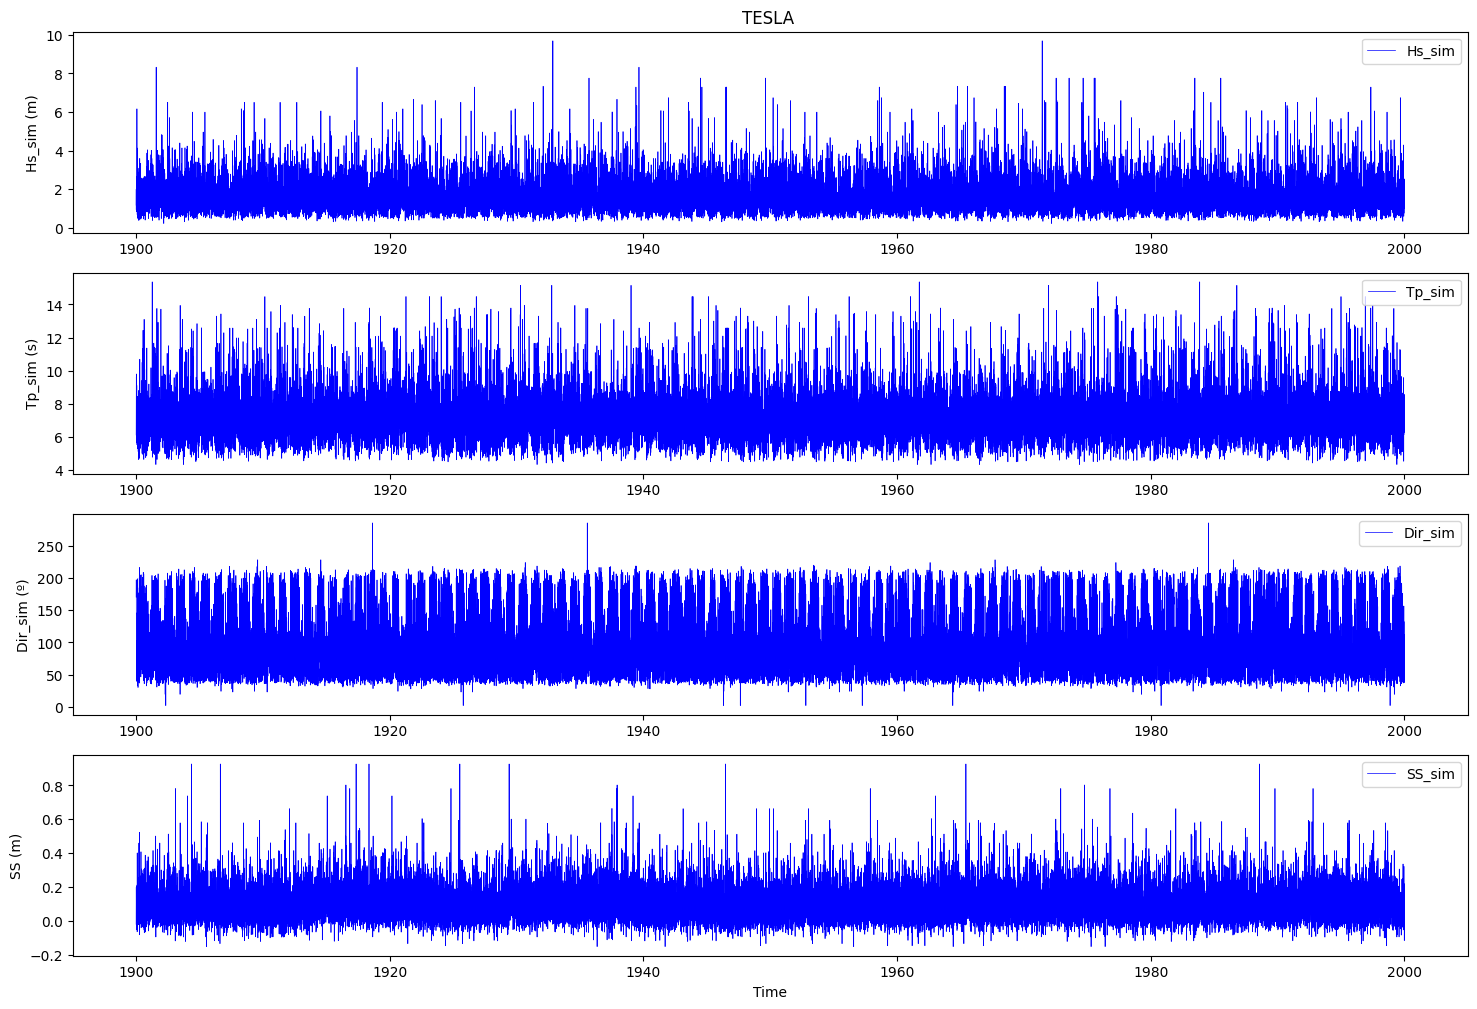

In [30]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(18,12))

#ax1

ax1.plot(
    ds_sim.time, ds_sim.sel(sim=0).Hs, '-b',
    linewidth = 0.5, label='Hs_sim',
)

ax1.set_ylabel('Hs_sim (m)')
ax1.legend(loc="upper right")
ax1.set_title('TESLA ')
#ax1.set_ylim(0,1)

#ax2

ax2.plot(
    ds_sim.time.time, ds_sim.sel(sim=0).Tp, '-b',
    linewidth = 0.5, label='Tp_sim',
)


ax2.set_ylabel('Tp_sim (s)')
ax2.legend(loc="upper right")
#ax2.set_ylim(0,1)

#ax3

ax3.plot(
    ds_sim.time, ds_sim.sel(sim=0).Dir, '-b',
    linewidth = 0.5, label='Dir_sim',
)


ax3.set_ylabel('Dir_sim (º)')
ax3.legend(loc="upper right")
#ax3.set_ylim(0,1)


#ax4

ax4.plot(
    ds_sim.time, ds_sim.sel(sim=0).ss, '-b',
    linewidth = 0.5, label='SS_sim',
)


ax4.set_ylabel('SS (m)')
#ax4.set_ylim(0,1)
ax4.legend(loc="upper right")
ax4.set_xlabel('Time')



In [31]:
## Hs
sim = 0
var = 'Hs'

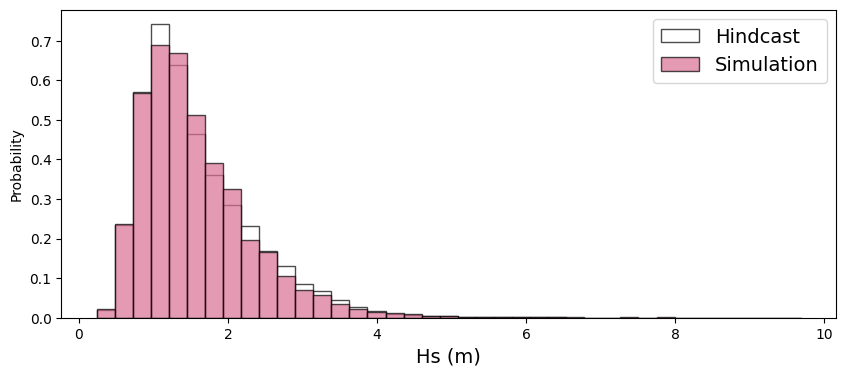

In [32]:
fig = plt.figure(figsize=[10,4])
gs2=gridspec.GridSpec(1,1)
ax1=fig.add_subplot(gs2[0])
ax1.hist(ds[var],bins=np.linspace(np.nanmin(ds_sim.sel(sim=sim)[var]),np.nanmax(ds_sim.sel(sim=sim)[var]),40), density=True,
         color='white',alpha=0.7,edgecolor='black',label='Hindcast')
ax1.hist(ds_sim.sel(sim=sim)[var],bins=np.linspace(np.nanmin(ds_sim.sel(sim=sim)[var]),np.nanmax(ds_sim.sel(sim=sim)[var]),40), density=True,
         color='palevioletred',alpha=0.7,edgecolor='black',label='Simulation')
ax1.set_xlabel('Hs (m)',fontsize=14)
ax1.set_ylabel('Probability')
ax1.legend(fontsize=14)

In [33]:
## Tp
sim = 0
var = 'Tp'

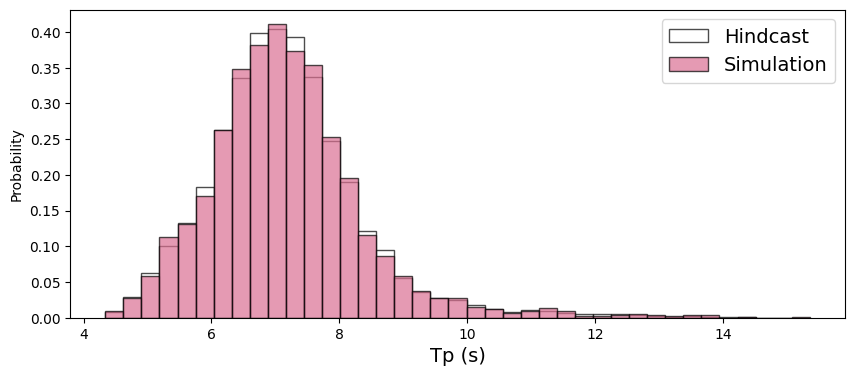

In [34]:
fig = plt.figure(figsize=[10,4])
gs2=gridspec.GridSpec(1,1)
ax1=fig.add_subplot(gs2[0])
ax1.hist(ds[var],bins=np.linspace(np.nanmin(ds_sim.sel(sim=sim)[var]),np.nanmax(ds_sim.sel(sim=sim)[var]),40), density=True,
         color='white',alpha=0.7,edgecolor='black',label='Hindcast')
ax1.hist(ds_sim.sel(sim=sim)[var],bins=np.linspace(np.nanmin(ds_sim.sel(sim=sim)[var]),np.nanmax(ds_sim.sel(sim=sim)[var]),40), density=True,
         color='palevioletred',alpha=0.7,edgecolor='black',label='Simulation')
ax1.set_xlabel('Tp (s)',fontsize=14)
ax1.set_ylabel('Probability')
ax1.legend(fontsize=14)

In [35]:
## Dir
sim = 0
var = 'Dir'

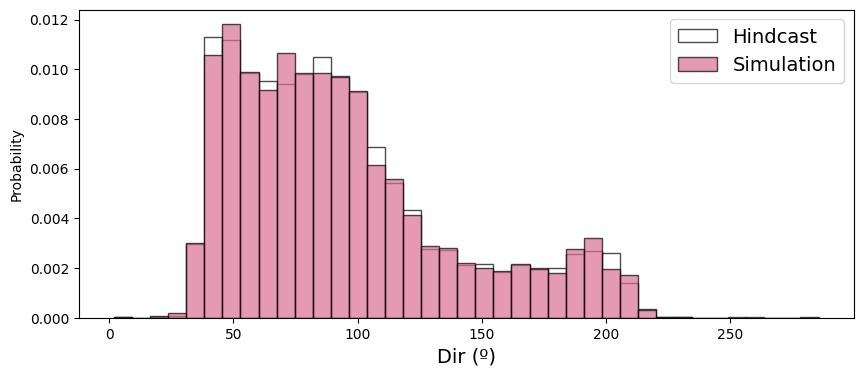

In [36]:
fig = plt.figure(figsize=[10,4])
gs2=gridspec.GridSpec(1,1)
ax1=fig.add_subplot(gs2[0])
ax1.hist(ds[var],bins=np.linspace(np.nanmin(ds_sim.sel(sim=sim)[var]),np.nanmax(ds_sim.sel(sim=sim)[var]),40), density=True,
         color='white',alpha=0.7,edgecolor='black',label='Hindcast')
ax1.hist(ds_sim.sel(sim=sim)[var],bins=np.linspace(np.nanmin(ds_sim.sel(sim=sim)[var]),np.nanmax(ds_sim.sel(sim=sim)[var]),40), density=True,
         color='palevioletred',alpha=0.7,edgecolor='black',label='Simulation')
ax1.set_xlabel('Dir (º)',fontsize=14)
ax1.set_ylabel('Probability')
ax1.legend(fontsize=14)

In [37]:
# SS
sim = 0
var = 'ss'

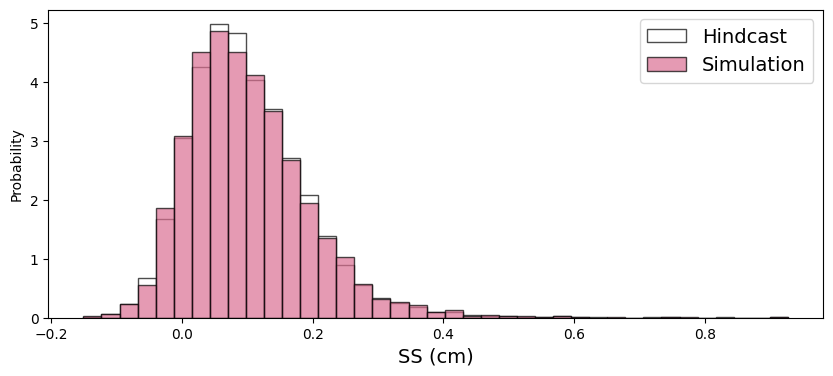

In [38]:
fig = plt.figure(figsize=[10,4])
gs2=gridspec.GridSpec(1,1)
ax1=fig.add_subplot(gs2[0])
ax1.hist(ds[var],bins=np.linspace(np.nanmin(ds_sim.sel(sim=sim)[var]),np.nanmax(ds_sim.sel(sim=sim)[var]),40), density=True,
         color='white',alpha=0.7,edgecolor='black',label='Hindcast')
ax1.hist(ds_sim.sel(sim=sim)[var],bins=np.linspace(np.nanmin(ds_sim.sel(sim=sim)[var]),np.nanmax(ds_sim.sel(sim=sim)[var]),40), density=True,
         color='palevioletred',alpha=0.7,edgecolor='black',label='Simulation')
ax1.set_xlabel('SS (cm)',fontsize=14)
ax1.set_ylabel('Probability')
ax1.legend(fontsize=14)

In [39]:
def t_rp(time_y):
    ny = len(time_y)
    return np.array([1/(1-(n/(ny+1))) for n in np.arange(1,ny+1)])

WVS_y=ds.resample(time='1Y').max()
WVS_sim_y=ds_sim.resample(time='1Y').max()
# WVS_y=CE.WVS_MS.resample(time='1Y').quantile(0.995)
# WVS_sim_y=WVS_sim.resample(time='1Y').quantile(0.995)

WVS_y_min=ds.resample(time='1Y').min()
WVS_sim_y_min=ds_sim.resample(time='1Y').min()

# RP calculation, var sorting historical
t_h = t_rp(WVS_y.time.dt.year)
t_s = t_rp(WVS_sim_y.time.dt.year)

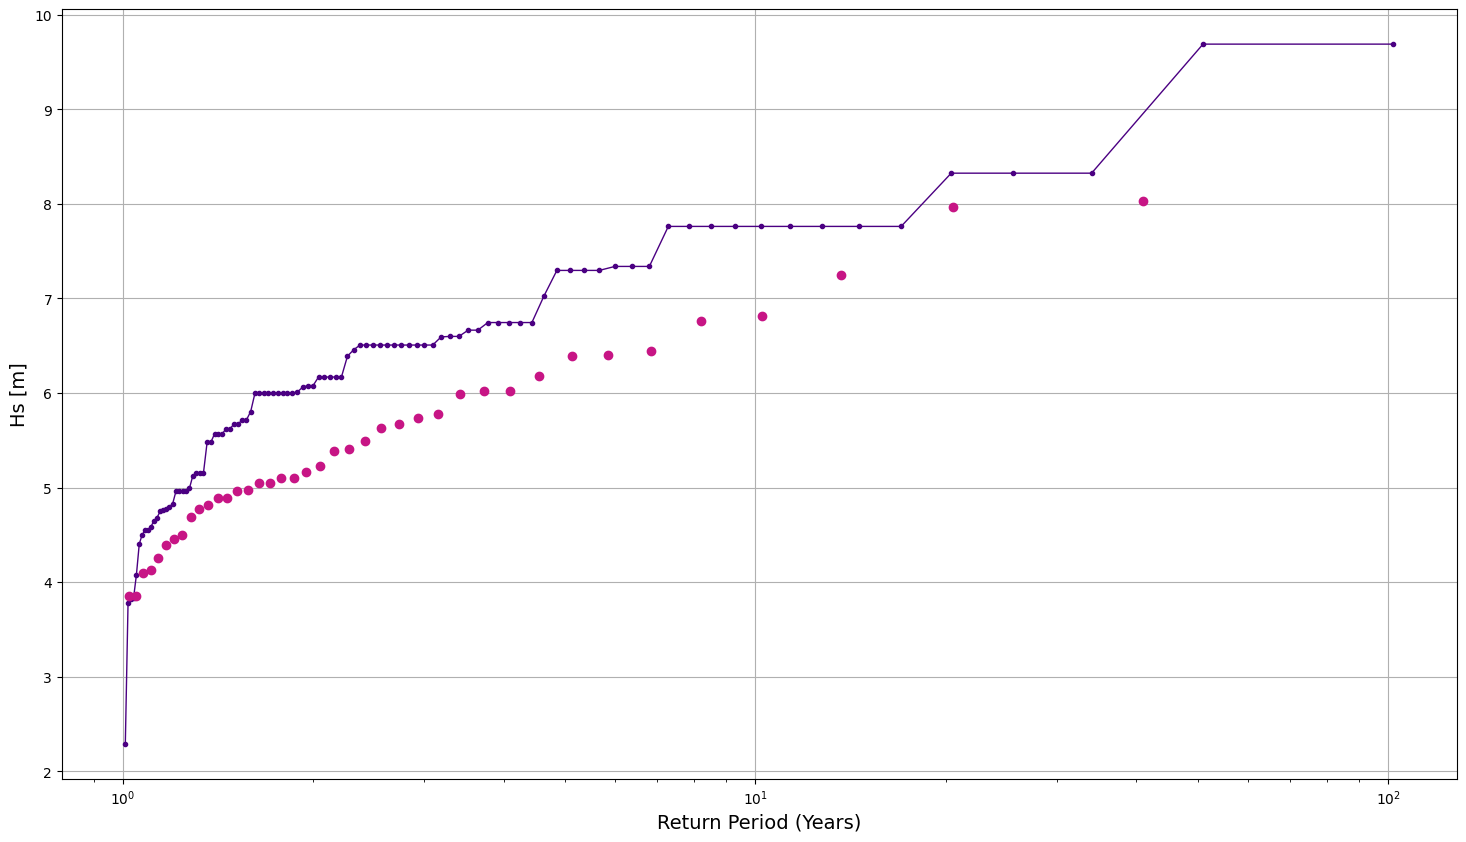

In [40]:
import matplotlib.pyplot as plt
from matplotlib import gridspec


fig = plt.figure(figsize=[18,10])
gs1=gridspec.GridSpec(1,1)
ax=fig.add_subplot(gs1[0])

ax.semilogx(t_h, np.sort(WVS_y.Hs.values), 'ok',color='mediumvioletred', markersize = 6, label = 'Historical', zorder=9,)
ax.set_ylabel('Hs [m]',fontsize=14)
ax.grid(True)

for n_sim_DWTs in range(len(ds_sim.sim)):
    WVS_sim = ds_sim.sel(sim=n_sim_DWTs)
    WVS_sim_y=WVS_sim.resample(time='1Y').max()

    ax.semilogx(t_s, np.sort(WVS_sim_y.Hs.values), '.-', color = 'indigo', linewidth = 1, label = 'Simulation {}'.format(n_sim_DWTs),  zorder=8,)

ax.set_xlabel('Return Period (Years)',fontsize=14)
ax.grid(True)